## Fetal Health - Model Building

In [1]:
import pandas as pd
import numpy as np
import optuna
from imblearn.over_sampling import SMOTE
import pickle

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score
import xgboost as xgb

#xgb_cl = xgb.XGBClassifier()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

C:\Users\Eric\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("fetal_health.csv")

In [3]:
df.head()

baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                             73.0                                   0.5   
1                             17.0                                   2.1   
2                             16.0                                   2.1   
3                             16.0                                   2.4   
4                             16.0                                   2.4   

   percentage_of_time_with_abnormal_long_term_variability  \
0                                               43.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   mean_value_of_long_term_variability  histogram_width  histogram_min  \
0                                  2.4             64.0           62.0   
1                                 10.4            130.0           68.0   
2                                 13.4            130.0           68.0   
3                                 23.0            117.0           53.0   
4                                 19.9            117.0           53.0   

   histogram_max  histogram_number_of_peaks  histogram_number_of_zeroes  \
0          126.0                        2.0                         0.0   
1          198.0                        6.0                         1.0   
2          198.0                        5.0                         1.0   
3          170.0                       11.0                         0.0   
4          170.0                        9.0                         0.0   

   histogram_mode  histogram_mean  histogram_median  histogram_variance  \
0           120.0           137.0             121.0                73.0   
1           141.0           136.0             140.0                12.0   
2           141.0           135.0             138.0                13.0   
3           137.0           134.0             137.0                13.0   
4           137.0           136.0             138.0                11.0   

   histogram_tendency  fetal_health  
0                 1.0           2.0  
1                 0.0           1.0  
2                 0.0           1.0  
3                 1.0           1.0  
4                 1.0           1.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

We know that we don't have any null values, so we don't have to worry about doing any missing value imputation.

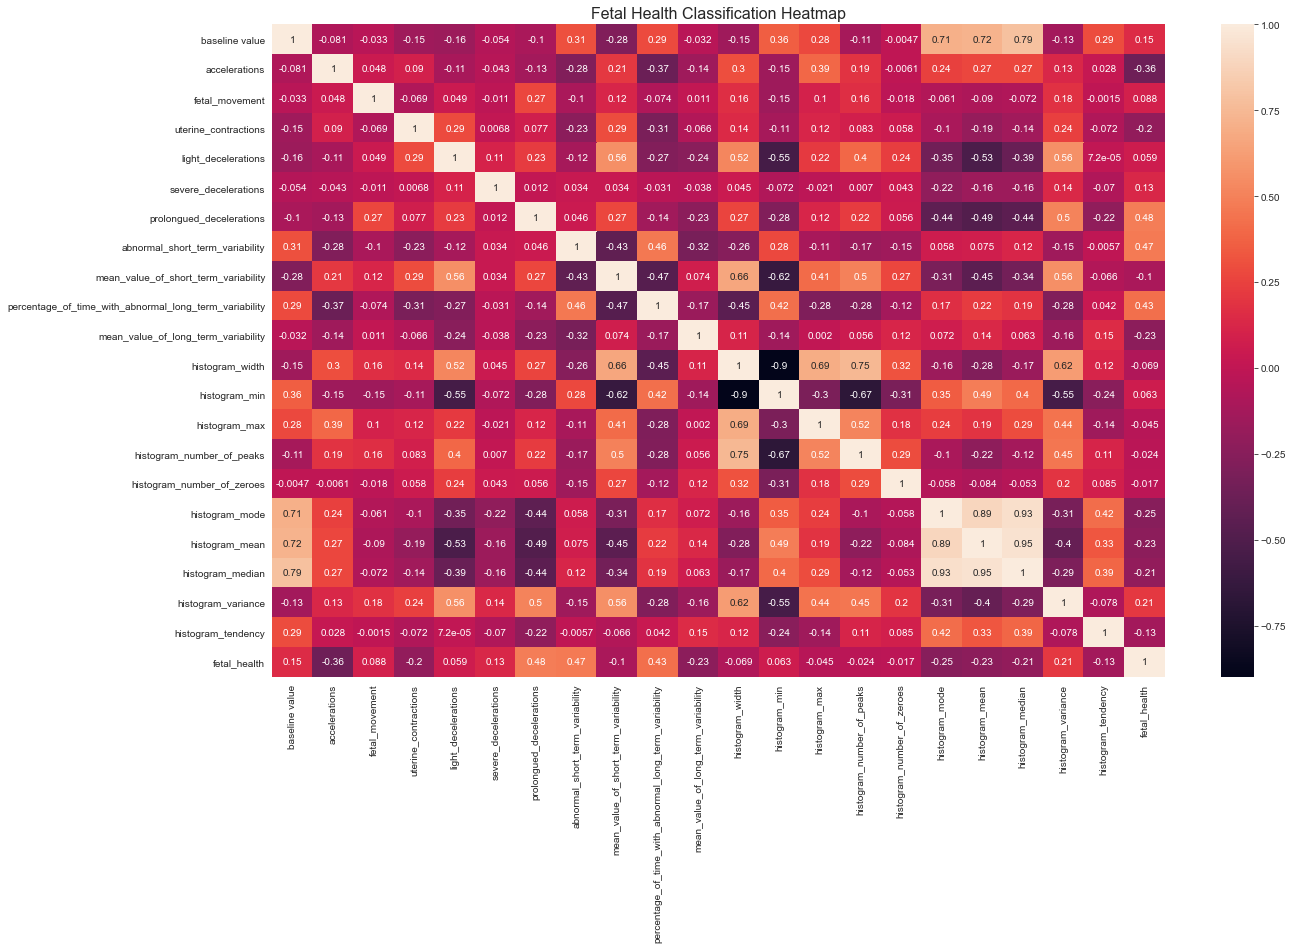

In [5]:
plt.figure(figsize=(20, 12)) 
plt.title('Fetal Health Classification Heatmap', fontsize=16)
heatmap = sns.heatmap(df.corr(), annot=True)

As we noticed in the EDA, the metrics of the exams are correlated. Since we'll perform LDA, we may be able to phase out these correlations that way. I'll also print each attribute's distribution in order to make a better decision on how to impute outliers.

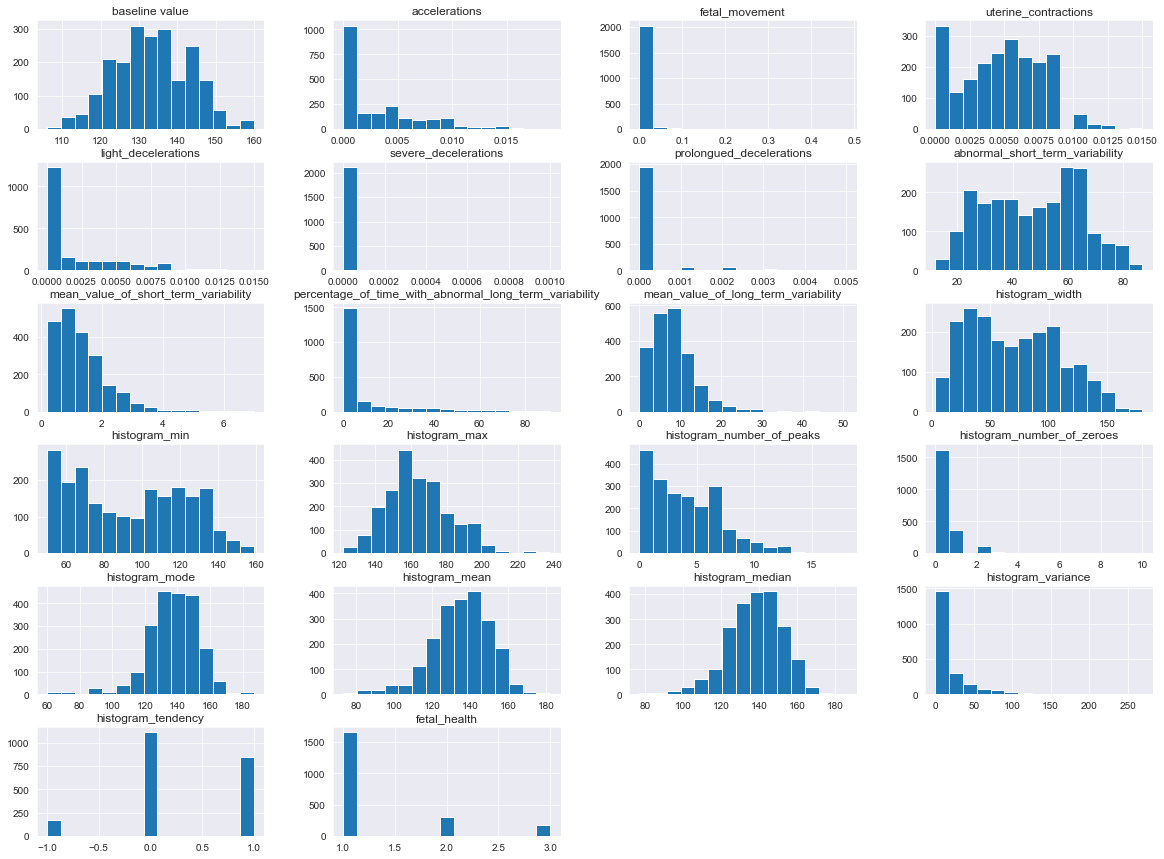

In [6]:
df.hist(bins=15, figsize=(20, 15), layout=(6, 4));

I want to print the current class distributions here again so that we can easily see the class imbalance as we move into outlier detection and potentially clustering. We saw from the box plots from EDA that there are some extremel outliers among some of the attributes. 

Since we are dealing with attributes of different scales measuring different elements of the cardiotocography exams. I will impute missing values with <b>IQR capping.</b>

In [7]:
df['fetal_health'].value_counts() #target value distributions

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

## Outlier Detection

We'll see what the data looks like after computing the IQR and capping/trimming the columns within the IQR.

In [8]:
iqr_cols = df.columns.tolist()[:-1] #all columns except the target

new_df = df.copy()

In [9]:
'''IQR'''
for col in iqr_cols:
    p_25 = new_df[col].quantile(0.25)
    p_75 = new_df[col].quantile(0.75)
    iqr = p_75 - p_25
    
    upper_limit = p_75 + (1.5 * iqr)
    lower_limit = p_25 + (1.5 * iqr)
    
    #Trimming Strategy:
    new_df.loc[new_df[col] > upper_limit, col] = upper_limit
    new_df.loc[new_df[col] < lower_limit, col] = lower_limit
    
    
    #Capping Strategy:
    #new_df[col] = np.where(
            #new_df[col] > upper_limit, upper_limit,
            #np.where(
                #new_df[col] < lower_limit, lower_limit, new_df[col] ))
    

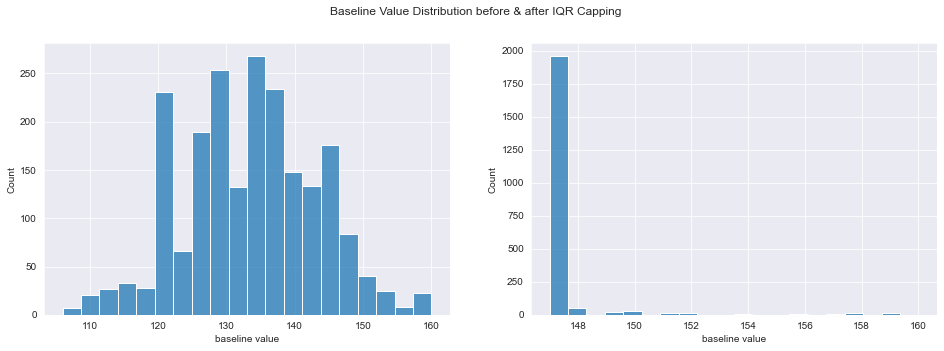

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
plt.suptitle('Baseline Value Distribution before & after IQR Capping')
sns.histplot(x='baseline value', data=df, bins=20, ax=axes[0])
sns.histplot(x='baseline value', data=new_df, bins=20, ax=axes[1])
plt.show()

It seems that even when binning the data with 20 bins after capping, most of the values in the heartrate baseline data gets shoved into a small range of values. For now let's continue while leaving the data alone. It is possible to also employ a clustering method to detect outliers.

## PCA Application

First, we're going to use PCA as a form of anomoly detection, I learned how to use it in this manner from: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis

In [11]:
X = df.loc[:, :'histogram_tendency']
y = df.loc[:, 'fetal_health']

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

comp_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=comp_names)

X_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.263977 -2.568375  1.302902  1.826119  0.379183 -0.326087 -2.254560   
1  1.954458  2.230317 -1.090115 -0.501233 -0.226035  0.672451  0.793729   
2  1.971485  1.968333 -1.286533 -0.210096 -0.554692  0.411061  1.554747   
3  2.222056  2.134027 -2.190836  1.601091 -0.046659 -0.428954  0.507563   
4  1.785438  2.190154 -2.508413  0.740641  0.267545 -0.259766 -0.109299   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.533575  0.252293  0.456495  0.232581  1.324954  1.761394  1.017870   
1 -0.555810  0.236623 -0.550629  0.012450  0.275320 -0.454686 -0.001353   
2 -0.145268 -0.204309 -0.554284 -0.247613  0.291970 -0.262157  0.052347   
3  0.390144 -1.804148 -0.229709 -0.698648  0.922679 -1.090830 -0.292555   
4  0.243573 -1.238910  0.326136 -0.812357  1.224144 -0.602461 -0.649632   

       PC15      PC16      PC17      PC18      PC19      PC20          PC21  
0  0.589256  0.774131 -0.312384  0.849963  0.788461 -0.667488 -4.313035e-15  
1 -1.183237  0.143357  0.090477 -0.158248 -0.089932  0.013280 -5.773896e-15  
2 -1.381607  0.323515  0.014106 -0.138219 -0.097598 -0.052837  1.233817e-15  
3  0.297691 -0.737588  0.381569  0.078602 -0.067854 -0.000435  1.610905e-15  
4 -0.027533 -0.434136  0.431303  0.309926 -0.182709 -0.005295 -5.440382e-15

In [14]:
loadings = pd.DataFrame(pca.components_.T, columns = comp_names, index=X.columns)

In [15]:
loadings

PC1       PC2  \
baseline value                                     -0.224146  0.277316   
accelerations                                       0.043423  0.278637   
fetal_movement                                      0.080645  0.038425   
uterine_contractions                                0.127398  0.027192   
light_decelerations                                 0.278643  0.020613   
severe_decelerations                                0.057744 -0.078264   
prolongued_decelerations                            0.202817 -0.113615   
abnormal_short_term_variability                    -0.145518 -0.122293   
mean_value_of_short_term_variability                0.316295  0.135011   
percentage_of_time_with_abnormal_long_term_vari... -0.217062 -0.140811   
mean_value_of_long_term_variability                -0.008054  0.096376   
histogram_width                                     0.313552  0.282859   
histogram_min                                      -0.332077 -0.142433   
histogram_max                                       0.133658  0.379433   
histogram_number_of_peaks                           0.251140  0.239990   
histogram_number_of_zeroes                          0.123175  0.127097   
histogram_mode                                     -0.262567  0.367239   
histogram_mean                                     -0.308815  0.325682   
histogram_median                                   -0.276006  0.376158   
histogram_variance                                  0.290681  0.100138   
histogram_tendency                                 -0.070344  0.225862   

                                                         PC3       PC4  \
baseline value                                      0.340075  0.059543   
accelerations                                      -0.186841 -0.435785   
fetal_movement                                      0.101702 -0.004773   
uterine_contractions                               -0.120827 -0.297931   
light_decelerations                                 0.200836  0.077951   
severe_decelerations                                0.071130  0.036292   
prolongued_decelerations                            0.336746 -0.096371   
abnormal_short_term_variability                     0.491748  0.092521   
mean_value_of_short_term_variability               -0.074591 -0.042994   
percentage_of_time_with_abnormal_long_term_vari...  0.320633  0.212111   
mean_value_of_long_term_variability                -0.432172  0.378401   
histogram_width                                     0.063889  0.105237   
histogram_min                                       0.029083 -0.282824   
histogram_max                                       0.186609 -0.237444   
histogram_number_of_peaks                           0.107529  0.157216   
histogram_number_of_zeroes                         -0.003772  0.295637   
histogram_mode                                      0.023271 -0.017329   
histogram_mean                                     -0.022153 -0.052817   
histogram_median                                    0.065643 -0.043112   
histogram_variance                                  0.265596 -0.095268   
histogram_tendency                                 -0.039212  0.478441   

                                                         PC5       PC6  \
baseline value                                     -0.082006 -0.025722   
accelerations                                       0.105234  0.107714   
fetal_movement                                      0.633875 -0.180036   
uterine_contractions                               -0.461380 -0.342192   
light_decelerations                                -0.354253 -0.178518   
severe_decelerations                               -0.200270  0.706669   
prolongued_decelerations                            0.282724 -0.160034   
abnormal_short_term_variability                    -0.052418  0.086371   
mean_value_of_short_term_variability               -0.070535 -0.050096   
percentage_of_time_with_abnormal_long_term_vari...  0.00596

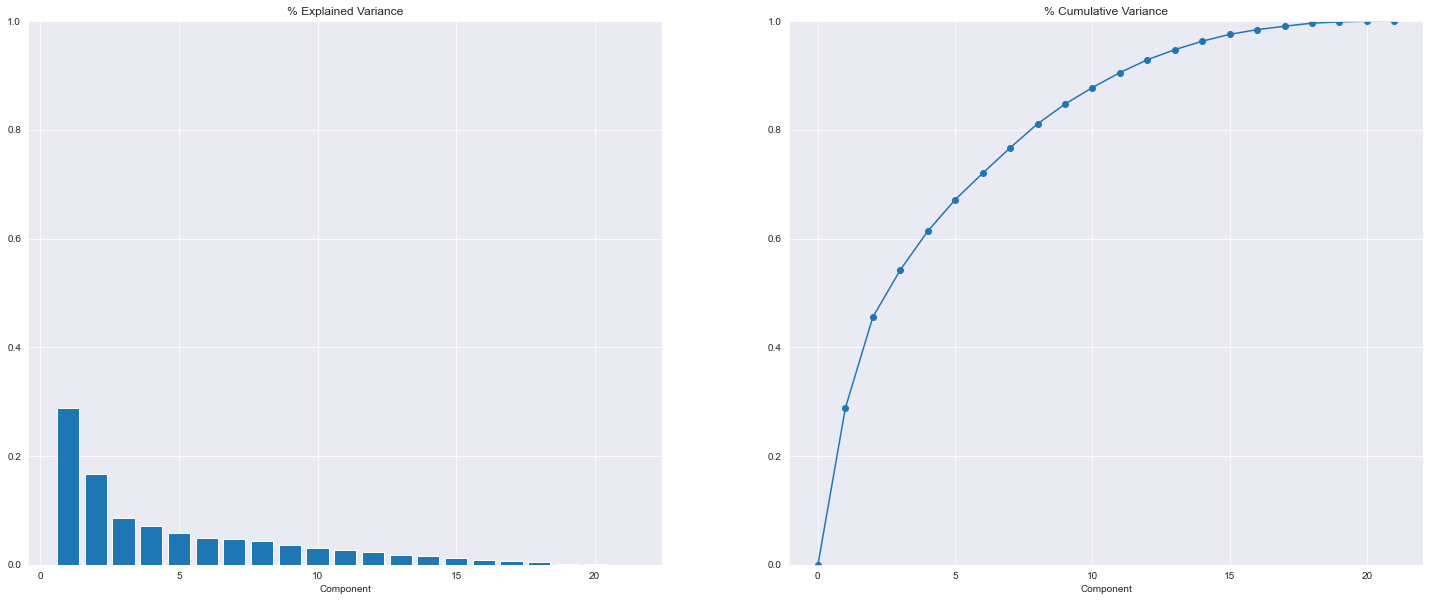

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(25,10))
n = pca.n_components_
grid = np.arange(1, n + 1)

evr = pca.explained_variance_ratio_
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
)

cv = np.cumsum(evr)
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].set(
    xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
)

plt.show()

It appears 8 principal components explain at least 80% of the variation within the data. Let's re-run PCA except with 8 components.

In [17]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

comp_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=comp_names)

X_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.263977 -2.568375  1.302899  1.826113  0.379199 -0.326087 -2.254615   
1  1.954458  2.230317 -1.090114 -0.501232 -0.226037  0.672451  0.793736   
2  1.971485  1.968333 -1.286533 -0.210095 -0.554694  0.411061  1.554756   
3  2.222056  2.134027 -2.190836  1.601091 -0.046660 -0.428954  0.507565   
4  1.785438  2.190154 -2.508413  0.740643  0.267540 -0.259766 -0.109284   

        PC8  
0 -0.533592  
1 -0.555808  
2 -0.145265  
3  0.390145  
4  0.243577

In [18]:
loadings = pd.DataFrame(pca.components_.T, columns = comp_names, index=X.columns)

In [19]:
loadings

PC1       PC2  \
baseline value                                     -0.224146  0.277316   
accelerations                                       0.043423  0.278637   
fetal_movement                                      0.080645  0.038425   
uterine_contractions                                0.127398  0.027192   
light_decelerations                                 0.278643  0.020613   
severe_decelerations                                0.057744 -0.078264   
prolongued_decelerations                            0.202817 -0.113615   
abnormal_short_term_variability                    -0.145518 -0.122293   
mean_value_of_short_term_variability                0.316295  0.135011   
percentage_of_time_with_abnormal_long_term_vari... -0.217062 -0.140811   
mean_value_of_long_term_variability                -0.008054  0.096376   
histogram_width                                     0.313552  0.282859   
histogram_min                                      -0.332077 -0.142433   
histogram_max                                       0.133658  0.379433   
histogram_number_of_peaks                           0.251140  0.239990   
histogram_number_of_zeroes                          0.123175  0.127097   
histogram_mode                                     -0.262567  0.367239   
histogram_mean                                     -0.308815  0.325682   
histogram_median                                   -0.276006  0.376158   
histogram_variance                                  0.290681  0.100138   
histogram_tendency                                 -0.070344  0.225862   

                                                         PC3       PC4  \
baseline value                                      0.340075  0.059543   
accelerations                                      -0.186841 -0.435785   
fetal_movement                                      0.101702 -0.004773   
uterine_contractions                               -0.120827 -0.297931   
light_decelerations                                 0.200836  0.077951   
severe_decelerations                                0.071130  0.036292   
prolongued_decelerations                            0.336746 -0.096372   
abnormal_short_term_variability                     0.491748  0.092521   
mean_value_of_short_term_variability               -0.074591 -0.042994   
percentage_of_time_with_abnormal_long_term_vari...  0.320633  0.212111   
mean_value_of_long_term_variability                -0.432172  0.378401   
histogram_width                                     0.063889  0.105237   
histogram_min                                       0.029083 -0.282824   
histogram_max                                       0.186609 -0.237444   
histogram_number_of_peaks                           0.107529  0.157216   
histogram_number_of_zeroes                         -0.003772  0.295637   
histogram_mode                                      0.023271 -0.017329   
histogram_mean                                     -0.022153 -0.052817   
histogram_median                                    0.065643 -0.043112   
histogram_variance                                  0.265596 -0.095268   
histogram_tendency                                 -0.039212  0.478441   

                                                         PC5       PC6  \
baseline value                                     -0.082007 -0.025722   
accelerations                                       0.105234  0.107714   
fetal_movement                                      0.633875 -0.180036   
uterine_contractions                               -0.461380 -0.342192   
light_decelerations                                -0.354253 -0.178518   
severe_decelerations                               -0.200270  0.706669   
prolongued_decelerations                            0.282724 -0.160034   
abnormal_short_term_variability                    -0.052418  0.086371   
mean_value_of_short_term_variability               -0.070535 -0.050096   
percentage_of_time_with_abnormal_long_term_vari...  0.00596

In [20]:
data_pca = pd.DataFrame(data = pca.components_,
                           columns = X.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8'])
data_pca

baseline value  accelerations  fetal_movement  \
Component 1       -0.224146       0.043423        0.080645   
Component 2        0.277316       0.278637        0.038425   
Component 3        0.340075      -0.186841        0.101702   
Component 4        0.059543      -0.435785       -0.004773   
Component 5       -0.082007       0.105234        0.633875   
Component 6       -0.025722       0.107714       -0.180036   
Component 7        0.245072      -0.430842        0.024939   
Component 8        0.188533      -0.118178        0.483888   

             uterine_contractions  light_decelerations  severe_decelerations  \
Component 1              0.127398             0.278643              0.057744   
Component 2              0.027192             0.020613             -0.078264   
Component 3             -0.120827             0.200836              0.071130   
Component 4             -0.297931             0.077951              0.036292   
Component 5             -0.461380            -0.354253             -0.200270   
Component 6             -0.342192            -0.178518              0.706669   
Component 7              0.229474            -0.039834             -0.202920   
Component 8              0.283271             0.087116              0.599790   

             prolongued_decelerations  abnormal_short_term_variability  \
Component 1                  0.202817                        -0.145518   
Component 2                 -0.113615                        -0.122293   
Component 3                  0.336746                         0.491748   
Component 4                 -0.096372                         0.092521   
Component 5                  0.282724                        -0.052418   
Component 6                 -0.160034                         0.086371   
Component 7                  0.212827                        -0.144735   
Component 8                  0.107634                        -0.206992   

             mean_value_of_short_term_variability  \
Component 1                              0.316295   
Component 2                              0.135011   
Component 3                             -0.074591   
Component 4                             -0.042994   
Component 5                             -0.070535   
Component 6                             -0.050096   
Component 7                              0.104429   
Component 8                              0.012101   

             percentage_of_time_with_abnormal_long_term_variability  \
Component 1                                          -0.217062        
Component 2                                          -0.140811        
Component 3                                           0.320633        
Component 4                                           0.212111        
Component 5                                           0.005961        
Component 6                                           0.026171        
Component 7                                           0.007022        
Component 8                                          -0.136872        

             mean_value_of_long_term_variability  histogram_width  \
Component 1                            -0.008054         0.313552   
Component 2                             0.096376         0.282859   
Component 3                            -0.432172         0.063889   
Component 4                             0.378401         0.105237   
Component 5                             0.191269         0.058189   
Component 6                             0.163257         0.087659   
Component 7                             0.399557        -0.081663   
Component 8                             0.063598        -0.124002   

             histogram_min  histogram_max  histogram_number_of_peaks  \
Component 1      -0.332077       0.133658                   0.251140   
Component 2      -0.142433       0.379433                   0.239990   
Component 3       0.029083       0.186609                   0.107529   
Component 4      -0.282824      -0.237

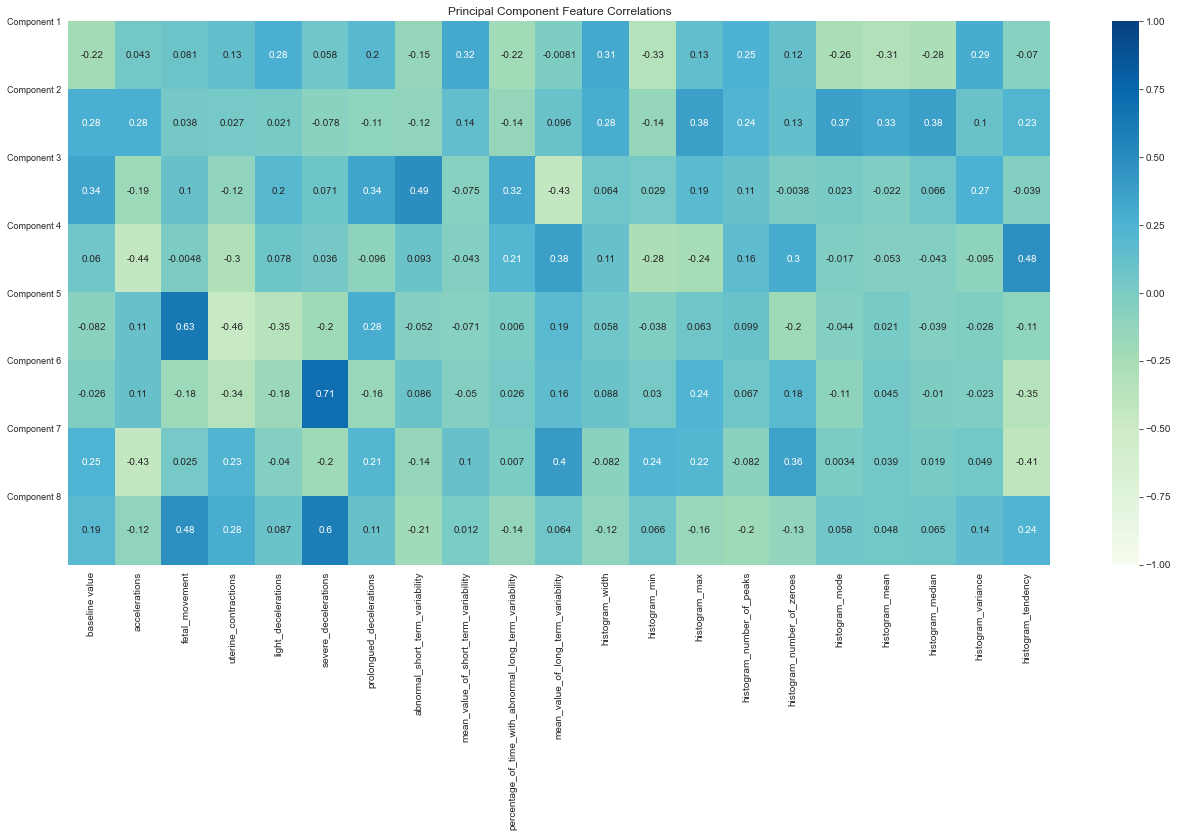

In [21]:
plt.figure(figsize=(22,10))
sns.heatmap(data_pca, vmin=-1, vmax=1, cmap='GnBu', annot=True)
plt.title('Principal Component Feature Correlations')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8'],rotation=0, fontsize=9)
plt.show()

Now I'll look at some of the lpca components within the data and look at differences.

In [22]:
component = "PC3"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["baseline value", "accelerations", "fetal_movement", 'uterine_contractions', 'light_decelerations', 'severe_decelerations', 'prolongued_decelerations', 'fetal_health']]

baseline value  accelerations  fetal_movement  uterine_contractions  \
1908           130.0          0.002           0.002                 0.008   
1907           130.0          0.002           0.002                 0.009   
1909           130.0          0.002           0.002                 0.008   
704            130.0          0.000           0.353                 0.000   
1755           134.0          0.003           0.000                 0.000   
...              ...            ...             ...                   ...   
1280           112.0          0.005           0.000                 0.007   
681            140.0          0.003           0.003                 0.004   
617            142.0          0.000           0.001                 0.002   
166            134.0          0.003           0.007                 0.001   
1580           132.0          0.000           0.000                 0.010   

      light_decelerations  severe_decelerations  prolongued_decelerations  \
1908                0.008                   0.0                     0.002   
1907                0.009                   0.0                     0.002   
1909                0.008                   0.0                     0.002   
704                 0.000                   0.0                     0.005   
1755                0.000                   0.0                     0.005   
...                   ...                   ...                       ...   
1280                0.002                   0.0                     0.000   
681                 0.000                   0.0                     0.000   
617                 0.000                   0.0                     0.000   
166                 0.000                   0.0                     0.000   
1580                0.000                   0.0                     0.000   

      fetal_health  
1908           3.0  
1907           3.0  
1909           3.0  
704            3.0  
1755           3.0  
...            ...  
1280           1.0  
681            1.0  
617            1.0  
166            1.0  
1580           1.0  

[2126 rows x 8 columns]

Looking at PC3 (since PC3 had the highest value for prolonged decelerations), we can see it found some differences with the pathological records being together on top. We have further confirmation that pathological records have more prolonged decelerations and the baseline heartrate falls within a certain range, which are a few things we found in our EDA.

PC1 had the highest value for light decelerations

In [23]:
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["baseline value", "accelerations", "fetal_movement", 'uterine_contractions', 'light_decelerations', 'severe_decelerations', 'prolongued_decelerations', 'fetal_health']]

baseline value  accelerations  fetal_movement  uterine_contractions  \
6              134.0          0.001           0.000                 0.013   
661            128.0          0.000           0.000                 0.006   
5              134.0          0.001           0.000                 0.010   
682            132.0          0.000           0.306                 0.004   
1908           130.0          0.002           0.002                 0.008   
...              ...            ...             ...                   ...   
126            159.0          0.000           0.000                 0.004   
402            151.0          0.000           0.000                 0.000   
821            152.0          0.000           0.000                 0.004   
130            158.0          0.000           0.000                 0.000   
132            158.0          0.000           0.000                 0.000   

      light_decelerations  severe_decelerations  prolongued_decelerations  \
6                   0.008                   0.0                     0.003   
661                 0.014                   0.0                     0.003   
5                   0.009                   0.0                     0.002   
682                 0.004                   0.0                     0.004   
1908                0.008                   0.0                     0.002   
...                   ...                   ...                       ...   
126                 0.000                   0.0                     0.000   
402                 0.000                   0.0                     0.000   
821                 0.000                   0.0                     0.000   
130                 0.000                   0.0                     0.000   
132                 0.000                   0.0                     0.000   

      fetal_health  
6              3.0  
661            2.0  
5              3.0  
682            3.0  
1908           3.0  
...            ...  
126            2.0  
402            2.0  
821            2.0  
130            1.0  
132            1.0  

[2126 rows x 8 columns]

We can see here that pathological and some suspect records have lower baseline heartrate and in this component, we have higher light decelerations along with uterine contractions in addition to prolonged decelerations, while normal and some suspect records have no prolonged decelerations.

I've noticed that fetal movement has a few outlying records in the above two component data frames. This perhaps is the kind of outlier we can expect within the data, but since we have only so much data, they may be important to us.

PC2 seems to have high values for the cardiotocography exam metrics, lets look at that next.

In [24]:
component = "PC2"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ['baseline value', "histogram_width", "histogram_min", "histogram_max", 'histogram_number_of_peaks', 'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean', 'histogram_median', 'histogram_variance', 'histogram_tendency', 'fetal_health']]

baseline value  histogram_width  histogram_min  histogram_max  \
141            154.0            147.0           50.0          197.0   
526            142.0            148.0           51.0          199.0   
181            138.0            148.0           52.0          200.0   
438            151.0            149.0           51.0          200.0   
552            136.0            148.0           52.0          200.0   
...              ...              ...            ...            ...   
1791           121.0            105.0           55.0          160.0   
1793           121.0            102.0           55.0          157.0   
1792           121.0            102.0           55.0          157.0   
1795           121.0            102.0           55.0          157.0   
1794           121.0            102.0           55.0          157.0   

      histogram_number_of_peaks  histogram_number_of_zeroes  histogram_mode  \
141                        10.0                        10.0           153.0   
526                        12.0                         0.0           180.0   
181                        11.0                         2.0           146.0   
438                        12.0                         8.0           156.0   
552                        11.0                         2.0           146.0   
...                         ...                         ...             ...   
1791                        7.0                         0.0            67.0   
1793                        5.0                         1.0            67.0   
1792                        4.0                         1.0            67.0   
1795                        6.0                         2.0            67.0   
1794                        3.0                         1.0            67.0   

      histogram_mean  histogram_median  histogram_variance  \
141            158.0             162.0                27.0   
526            164.0             171.0                53.0   
181            157.0             161.0                72.0   
438            150.0             157.0                56.0   
552            159.0             162.0                74.0   
...              ...               ...                 ...   
1791            85.0              92.0               109.0   
1793            83.0              90.0                98.0   
1792            81.0              87.0                89.0   
1795            76.0              79.0                68.0   
1794            79.0              82.0                83.0   

      histogram_tendency  fetal_health  
141                  1.0           1.0  
526                  1.0           1.0  
181                  1.0           1.0  
438                  1.0           2.0  
552                  1.0           1.0  
...                  ...           ...  
1791                -1.0           3.0  
1793                -1.0           3.0  
1792                -1.0           3.0  
1795                -1.0           3.0  
1794                -1.0           3.0  

[2126 rows x 12 columns]

The exam graph tendency for normal records indicates a positive trend, while for pathological records a negative trend. I also included baseline heartrate here as well. 

It seems pathological records have a trace of lower baseline heartrates and a shorter exam graph. Pathological records also have lower mean, mode, and median values in their graphs and consistent patterns between those and normal records. Again, we noticed this in our EDA, and our PCA analysis here backs it up!

Since the anomolies I noticed may be important to retain, I'll choose to keep them.

## KMeans Feature Application

Could we develop clustering of the 3 classes of our target variable using KMeans?

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Saving the scaler for Flask implementation
pickl = {'km_scaler' : scaler}
pickle.dump(pickl, open('km_scaler.pkl', 'wb'))

In [26]:
wcss=[]

for i in range(1,10):
    kmeans=KMeans(i, init='k-means++')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
wcss

[44645.99999999991,
 36342.149840227634,
 32396.794378591476,
 29000.0268879371,
 26835.957204903796,
 25086.422778559463,
 23313.01465830242,
 22021.92069129947,
 21019.04809882981]

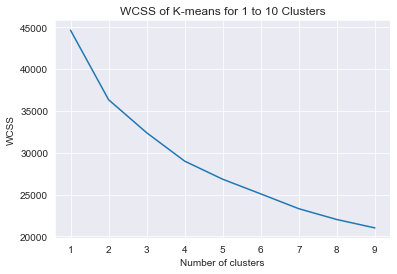

In [27]:
plt.plot(range(1,10),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title("WCSS of K-means for 1 to 10 Clusters")
plt.show()

In [28]:
kmeans_new=KMeans(3, init='k-means++')
kmeans_new.fit(X_scaled)
clusters_new=X.copy()
clusters_new['cluster_pred']=kmeans_new.fit_predict(X_scaled)

In [29]:
#Saving the kmeans model for Flask implementation
pickl = {'kmeans' : kmeans_new}
pickle.dump(pickl, open('kmeans.pkl', 'wb'))

In [30]:
#based on the X data, we need to save the above scaler, used the scaled data and run thru the trained
#kmeans model made above with predict, and that is how we will get the KMeans value. 

In [31]:
class_compare = pd.concat([clusters_new['cluster_pred'], y], axis=1)

In [32]:
class_compare

cluster_pred  fetal_health
0                2           2.0
1                1           1.0
2                1           1.0
3                1           1.0
4                1           1.0
...            ...           ...
2121             2           2.0
2122             2           2.0
2123             2           2.0
2124             2           2.0
2125             2           1.0

[2126 rows x 2 columns]

In [33]:
len(np.where(class_compare['cluster_pred']==class_compare['fetal_health'])[0])

1283

We can try to plot these KMeans cluster features and see how well they go with the data. Then, if they can be used reliably as features, we could include these clusters in our data.

In [34]:
features = ['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'light_decelerations', 'severe_decelerations', 'prolongued_decelerations']

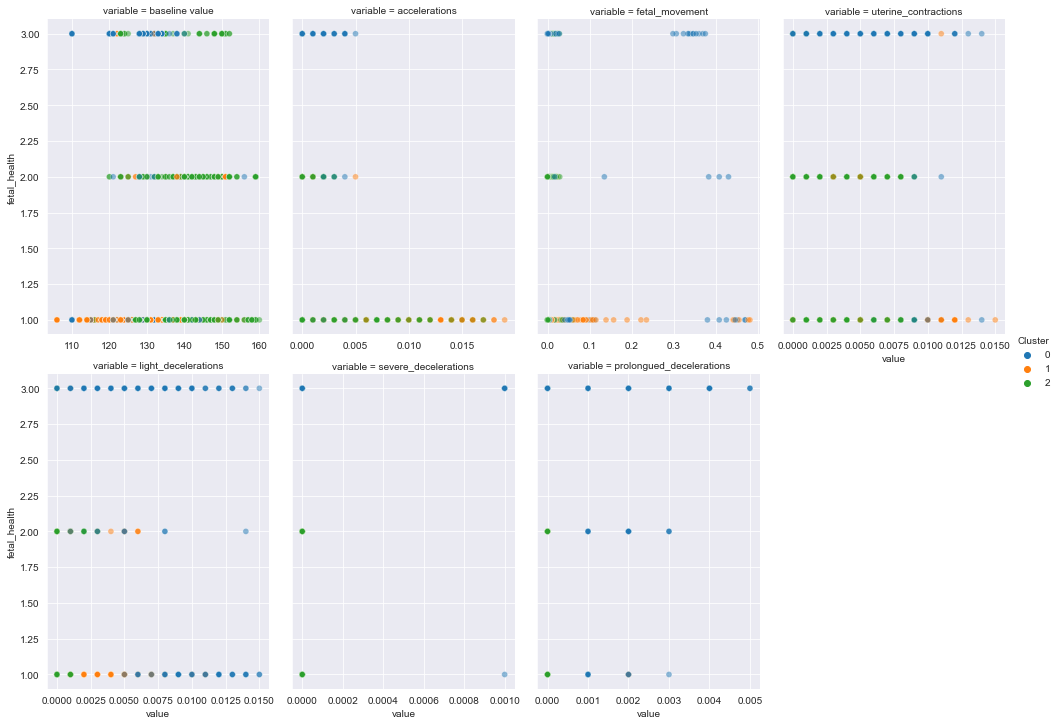

In [35]:
X_clus = X.copy()
X_clus["Cluster"] = class_compare.cluster_pred.astype("category")
X_clus["fetal_health"] = y
sns.relplot(
    x="value", y="fetal_health", hue="Cluster", col="variable", alpha=0.5,
    height=5, aspect=0.7, facet_kws={'sharex': False}, col_wrap=4,
    data=X_clus.melt(
        value_vars=features, id_vars=["fetal_health", "Cluster"],
    ),
);

We can see some separation between the clusters when plotting with these select features, we can try to model with and without these cluster features and see how model performance is impacted.

In [36]:
#COMMENT OUT if you wish not to use the cluster feature
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
#lbl.fit_transform(class_compare['cluster_pred'].astype(str))
X['kmeans_cluster'] = lbl.fit_transform(class_compare['cluster_pred'].astype(str)) #model does slightly better WITH this feature

#try object if category becomes an issue

In [37]:
#perhaps lets also save this label encoder

#Saving the scaler for Flask implementation
pickl = {'lbl_encoder' : lbl}
pickle.dump(pickl, open('lbl_encoder.pkl', 'wb'))

## LDA Application

Now that we've seen what values and attributes best separate the data, lets now conduct LDA on the classes in question (fetal_health) and see if they are split in a similar manner.

Since we have 3 classes, we can use LDA to split the classes into 2 linear discriminants.

Helpful blog on implementation: https://www.mygreatlearning.com/blog/linear-discriminant-analysis-or-lda/

In [38]:
lda = LDA(n_components=2)

In [39]:
X_lda = lda.fit_transform(X, y) #X_scaled

In [40]:
lda.explained_variance_ratio_

#before adding kmeans: array([0.8035912, 0.1964088])

array([0.80562399, 0.19437601])

In [41]:
X_lda[:,0]

array([ 1.7946912 , -1.75365208, -1.74385244, ...,  0.27729303,
        0.65637137,  1.13782921])

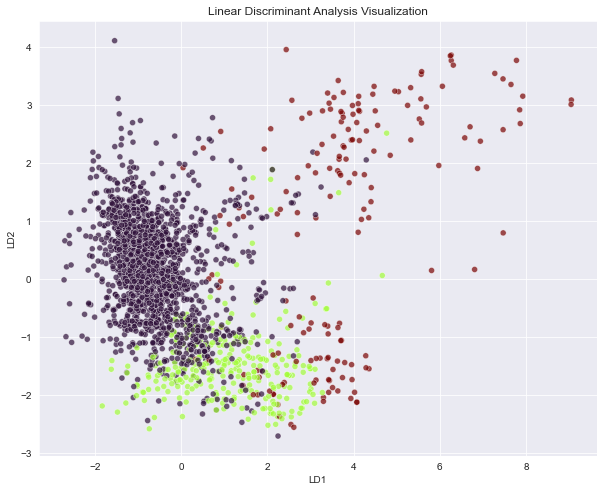

In [42]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=X_lda[:,0], y=X_lda[:,1], c=y, cmap='turbo', alpha=0.7, edgecolors='black')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Linear Discriminant Analysis Visualization')
plt.show()

In [43]:
X_lda.shape

(2126, 2)

Now we can try to build a model using these LDA components that conveniently resulted in 2-dimensions for us to plot above.

In [44]:
X.head() #you apply scaler AFTER calling train_test_split!!

baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                             73.0                                   0.5   
1                             17.0                                   2.1   
2                             16.0                                   2.1   
3                             16.0                                   2.4   
4                             16.0                                   2.4   

   percentage_of_time_with_abnormal_long_term_variability  \
0                                               43.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   mean_value_of_long_term_variability  histogram_width  histogram_min  \
0                                  2.4             64.0           62.0   
1                                 10.4            130.0           68.0   
2                                 13.4            130.0           68.0   
3                                 23.0            117.0           53.0   
4                                 19.9            117.0           53.0   

   histogram_max  histogram_number_of_peaks  histogram_number_of_zeroes  \
0          126.0                        2.0                         0.0   
1          198.0                        6.0                         1.0   
2          198.0                        5.0                         1.0   
3          170.0                       11.0                         0.0   
4          170.0                        9.0                         0.0   

   histogram_mode  histogram_mean  histogram_median  histogram_variance  \
0           120.0           137.0             121.0                73.0   
1           141.0           136.0             140.0                12.0   
2           141.0           135.0             138.0                13.0   
3           137.0           134.0             137.0                13.0   
4           137.0           136.0             138.0                11.0   

   histogram_tendency  kmeans_cluster  
0                 1.0               2  
1                 0.0               1  
2                 0.0               1  
3                 1.0               1  
4                 1.0               1

In [45]:
pickl = {'lda' : lda}
pickle.dump(pickl, open('lda.pkl', 'wb'))

## Model Building
We can try to build models using X_lda, our regular X dataset, (or maybe combine both?)

We can try to make a case for choosing particular models:

* SVM: We want to try to separate our classes (target being fetal_health) as best we can, therefore this model is a rational choice.


* KnearestNeighbors: Since the class splits have been separable based on distance for many attributes.


* Random Forest Classifier: There are many thresholds in the data where there is a clear distinction what the dominant group is in a given attribute's array of values.


* AdaBoost, XGBoost and CatBoost: More powerful tree-based algorithms.

In [46]:
#Run if we want both X w/ X_lda
X_all = pd.concat([X, pd.DataFrame(X_lda, columns=['LD1', 'LD2'])], axis=1)
X_all.head() #So it could have X, kmeans, and LDA info.

baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                             73.0                                   0.5   
1                             17.0                                   2.1   
2                             16.0                                   2.1   
3                             16.0                                   2.4   
4                             16.0                                   2.4   

   percentage_of_time_with_abnormal_long_term_variability  \
0                                               43.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   mean_value_of_long_term_variability  histogram_width  histogram_min  \
0                                  2.4             64.0           62.0   
1                                 10.4            130.0           68.0   
2                                 13.4            130.0           68.0   
3                                 23.0            117.0           53.0   
4                                 19.9            117.0           53.0   

   histogram_max  histogram_number_of_peaks  histogram_number_of_zeroes  \
0          126.0                        2.0                         0.0   
1          198.0                        6.0                         1.0   
2          198.0                        5.0                         1.0   
3          170.0                       11.0                         0.0   
4          170.0                        9.0                         0.0   

   histogram_mode  histogram_mean  histogram_median  histogram_variance  \
0           120.0           137.0             121.0                73.0   
1           141.0           136.0             140.0                12.0   
2           141.0           135.0             138.0                13.0   
3           137.0           134.0             137.0                13.0   
4           137.0           136.0             138.0                11.0   

   histogram_tendency  kmeans_cluster       LD1       LD2  
0                 1.0               2  1.794691 -1.343696  
1                 0.0               1 -1.753652  0.503266  
2                 0.0               1 -1.743852  0.273472  
3                 1.0               1 -1.769798  0.428170  
4                 1.0               1 -1.839251  1.146818

In [47]:
X.head()

baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                             73.0                                   0.5   
1                             17.0                                   2.1   
2                             16.0                                   2.1   
3                             16.0                                   2.4   
4                             16.0                                   2.4   

   percentage_of_time_with_abnormal_long_term_variability  \
0                                               43.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   mean_value_of_long_term_variability  histogram_width  histogram_min  \
0                                  2.4             64.0           62.0   
1                                 10.4            130.0           68.0   
2                                 13.4            130.0           68.0   
3                                 23.0            117.0           53.0   
4                                 19.9            117.0           53.0   

   histogram_max  histogram_number_of_peaks  histogram_number_of_zeroes  \
0          126.0                        2.0                         0.0   
1          198.0                        6.0                         1.0   
2          198.0                        5.0                         1.0   
3          170.0                       11.0                         0.0   
4          170.0                        9.0                         0.0   

   histogram_mode  histogram_mean  histogram_median  histogram_variance  \
0           120.0           137.0             121.0                73.0   
1           141.0           136.0             140.0                12.0   
2           141.0           135.0             138.0                13.0   
3           137.0           134.0             137.0                13.0   
4           137.0           136.0             138.0                11.0   

   histogram_tendency  kmeans_cluster  
0                 1.0               2  
1                 0.0               1  
2                 0.0               1  
3                 1.0               1  
4                 1.0               1

### SMOTE Implementation (update):
Since we have very imbalanced target records, we can try to implement SMOTE in order to upsample the underrepresented target values and obtain a more balanced dataset for model building.

We do have to be aware this while it may improve the evaluation metrics of the models, this isn't a genuine depiction of the real world as this is artificial data being used.

In [48]:
smote = SMOTE(random_state=3)
X_smote, y_smote = smote.fit_resample(X_all, y)

In [49]:
y_smote.value_counts()

2.0    1655
1.0    1655
3.0    1655
Name: fetal_health, dtype: int64

In [50]:
X_smote.head()

baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                             73.0                                   0.5   
1                             17.0                                   2.1   
2                             16.0                                   2.1   
3                             16.0                                   2.4   
4                             16.0                                   2.4   

   percentage_of_time_with_abnormal_long_term_variability  \
0                                               43.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   mean_value_of_long_term_variability  histogram_width  histogram_min  \
0                                  2.4             64.0           62.0   
1                                 10.4            130.0           68.0   
2                                 13.4            130.0           68.0   
3                                 23.0            117.0           53.0   
4                                 19.9            117.0           53.0   

   histogram_max  histogram_number_of_peaks  histogram_number_of_zeroes  \
0          126.0                        2.0                         0.0   
1          198.0                        6.0                         1.0   
2          198.0                        5.0                         1.0   
3          170.0                       11.0                         0.0   
4          170.0                        9.0                         0.0   

   histogram_mode  histogram_mean  histogram_median  histogram_variance  \
0           120.0           137.0             121.0                73.0   
1           141.0           136.0             140.0                12.0   
2           141.0           135.0             138.0                13.0   
3           137.0           134.0             137.0                13.0   
4           137.0           136.0             138.0                11.0   

   histogram_tendency  kmeans_cluster       LD1       LD2  
0                 1.0               2  1.794691 -1.343696  
1                 0.0               1 -1.753652  0.503266  
2                 0.0               1 -1.743852  0.273472  
3                 1.0               1 -1.769798  0.428170  
4                 1.0               1 -1.839251  1.146818

Now we can try out these models with SMOTE implemented and see if we get a difference.

In [51]:
#We use stratify set to y since the classes are imbalanced in this data.
#Sub out X_all for X_lda or X depending on what you want to test.

#X_all > X_lda, where X_all contains X_lda
#X_all > X where X also has the clusters.
#                                                   X_smote  y_smote
X_train, X_test, y_train, y_test  = train_test_split(X_all, y, test_size=0.25, random_state=3, stratify=y) 

In [52]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

X_train:  (1594, 24)
X_test:  (532, 24)
y_train:  (1594,)
y_test:  (532,)


In [53]:
mm_scaler = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train_svm = mm_scaler.transform(X_train)
#X_test_svm = mm_scaler.transform(X_test)

Since we are trying to separate classes here as a priority, we're going to try SVM with GridSearchCV. Since SVM requires values to be between -1 and 1, we'll use MinMaxScaler for this algorithm.

<b>Support Vector Machine:</b>

In [54]:
param_grid = {'C': [1, 2, 5, 10, 20], 'kernel': ('rbf', 'sigmoid')}

svm = SVC(random_state=3, max_iter=-1)

clf = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1)
clf.fit(X_train_svm, y_train)

print('GridSearch Best Estimator: {}'.format(clf.best_estimator_))
print('GridSearch Best Parameters: {}'.format(clf.best_params_))
print()
print('Support Vector Machine Accuracy: {:.2%}'.format(clf.score(mm_scaler.transform(X_test), y_test)))

GridSearch Best Estimator: SVC(C=20, random_state=3)
GridSearch Best Parameters: {'C': 20, 'kernel': 'rbf'}

Support Vector Machine Accuracy: 91.54%


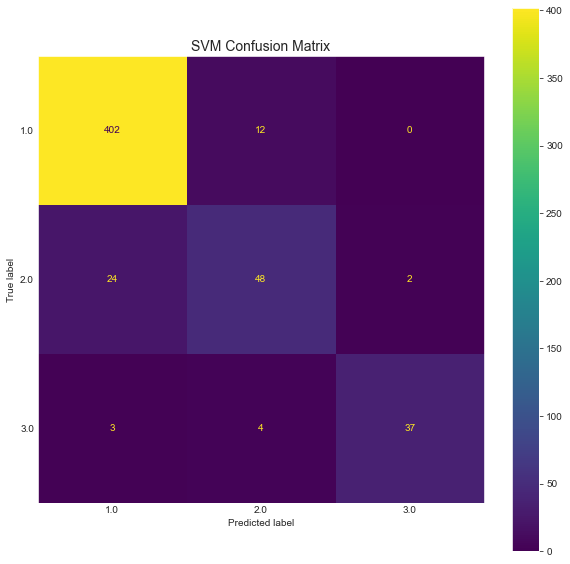

In [55]:
y_pred = clf.predict(mm_scaler.transform(X_test))

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('SVM Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

In [56]:
print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological'])) #classes coming from 1, 2, and 3

              precision    recall  f1-score   support

      Normal       0.94      0.97      0.95       414
     Suspect       0.75      0.65      0.70        74
Pathological       0.95      0.84      0.89        44

    accuracy                           0.92       532
   macro avg       0.88      0.82      0.85       532
weighted avg       0.91      0.92      0.91       532



Since the suspect records come between normal and pathological estimates, it isn't much of a surprise that the model has the hardest time classifying those records. The model does slightly better if we choose to NOT stratify on y. We wanted to do this since the classes are imbalanced. 

However, it's interesting that our results are improved overall with stratify turned off.

<b>Update:</b> After implementing SMOTE, the evaluation metrics across all targets increased.

Since the model can classify by proximity, let's next try 

<b>K Nearest Neighbors:</b>

In [57]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
pickl = {'sample_scaler' : scaler}
pickle.dump(pickl, open('sample_scaler.pkl', 'wb'))

In [59]:
#only run up to HERE!!!

In [60]:
param_grid = {'n_neighbors': [1, 5, 10, 20, 50], 'weights': ['uniform', 'distance'], 'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')}

knn = KNeighborsClassifier()

clf = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1)
clf.fit(X_train, y_train)

print('GridSearch Best Estimator: {}'.format(clf.best_estimator_))
print('GridSearch Best Parameters: {}'.format(clf.best_params_))
print()
print('KNeighbors Classifier Accuracy: {:.2%}'.format(clf.score(X_test, y_test)))

GridSearch Best Estimator: KNeighborsClassifier(weights='distance')
GridSearch Best Parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}

KNeighbors Classifier Accuracy: 90.98%


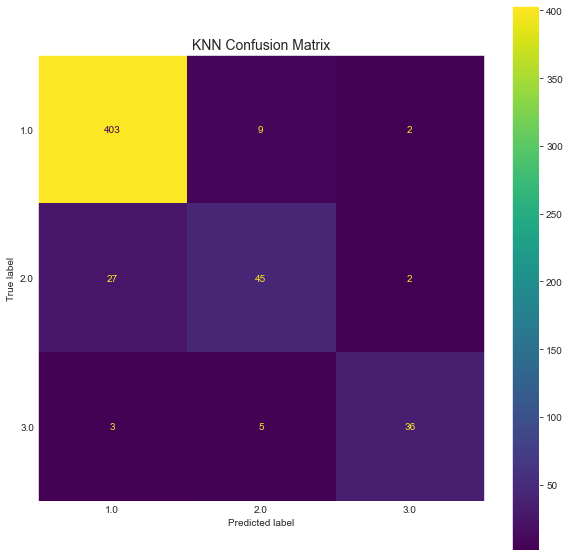

In [61]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('KNN Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

In [62]:
print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))

              precision    recall  f1-score   support

      Normal       0.93      0.97      0.95       414
     Suspect       0.76      0.61      0.68        74
Pathological       0.90      0.82      0.86        44

    accuracy                           0.91       532
   macro avg       0.86      0.80      0.83       532
weighted avg       0.90      0.91      0.91       532



It looks like the KNeighbors Classifier did a little better for normal records, but slightly worse for suspect and pathological records. 

<b>Update:</b> The SMOTE implementation also improved the results of our KNN implementation.



<b>Logistic Regression:</b>

In [63]:
param_grid = {'penalty': ['l1', 'l2'], 'solver': ('lbfgs', 'liblinear'),
              'C': [1, 2, 5, 10, 20]}

logreg = LogisticRegression(max_iter=500, random_state=3, multi_class='ovr', n_jobs=-1)

clf = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)
clf.fit(X_train, y_train)

print('GridSearch Best Estimator: {}'.format(clf.best_estimator_))
print('GridSearch Best Parameters: {}'.format(clf.best_params_))
print()
print('Logistic Regression Accuracy: {:.2%}'.format(clf.score(X_test, y_test)))

GridSearch Best Estimator: LogisticRegression(C=1, max_iter=500, multi_class='ovr', n_jobs=-1,
                   penalty='l1', random_state=3, solver='liblinear')
GridSearch Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Logistic Regression Accuracy: 89.85%


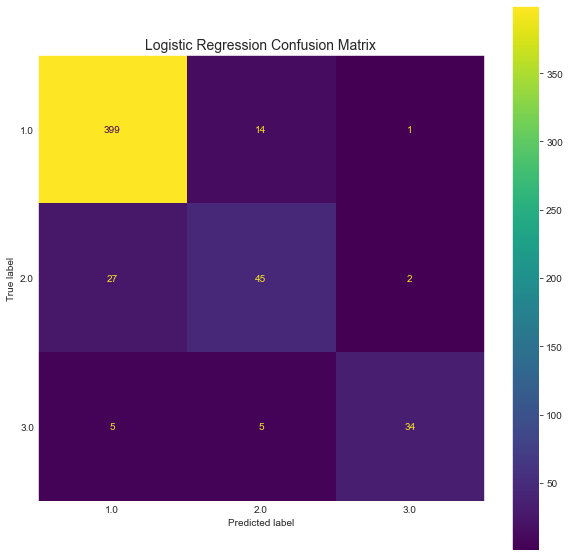

In [64]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('Logistic Regression Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

In [65]:
print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))

              precision    recall  f1-score   support

      Normal       0.93      0.96      0.94       414
     Suspect       0.70      0.61      0.65        74
Pathological       0.92      0.77      0.84        44

    accuracy                           0.90       532
   macro avg       0.85      0.78      0.81       532
weighted avg       0.89      0.90      0.90       532



Logistic Regression doesn't perform as well as the previous two classifier algorithms, though not by much.

In this version of SMOTE, I will just straight to the last CatBoost model run.

### Stratified KFold w/ Random Forest & AdaBoost Classifier
Let's now try a different approach using Stratified KFold with the Random Forest Classifier

In [66]:
#Recreating X_scaled to fit the X_smote data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_smote)

In [67]:
rf = RandomForestClassifier(random_state=3, n_estimators=1000)

skf_scores = []
skf_f1scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

for i, (train_idx, test_idx) in enumerate(skf.split(X_smote, y_smote)): #changing to X_smote and y_smote
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx] #We want to use scaled values.
    y_train, y_test = y_smote[train_idx], y_smote[test_idx]
    
    rf.fit(X_train, y_train)
    skf_scores.append(rf.score(X_test, y_test))
    
    y_pred = rf.predict(X_test)
    #print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))
    
    print('Fold {} F1 Score: {:.2%}'.format(i+1, f1_score(y_test, y_pred, average='micro'))) #micro to peform global f1 score
    skf_f1scores.append(f1_score(y_test, y_pred, average='micro'))
    
print("List of Accuracies: {}".format(skf_scores))

print()
print("Mean of Accuracies: {:.2%}".format(np.mean(skf_scores)))
print("Mean of F1 Scores: {:.2%}".format(np.mean(skf_f1scores)))

Fold 1 F1 Score: 97.89%
Fold 2 F1 Score: 97.38%
Fold 3 F1 Score: 97.48%
Fold 4 F1 Score: 97.99%
Fold 5 F1 Score: 98.39%
List of Accuracies: [0.9788519637462235, 0.973816717019134, 0.9748237663645518, 0.9798590130916415, 0.9838872104733132]

Mean of Accuracies: 97.82%
Mean of F1 Scores: 97.82%


In [68]:
#For ROC AUC at the bottom of the notebook:

rf = RandomForestClassifier(random_state=3, n_estimators=2000, criterion='gini')

rf.fit(X_train, y_train)

print('Random Forest Classifier Accuracy: {:.2%}'.format(rf.score(X_test, y_test)))

Random Forest Classifier Accuracy: 98.39%


It looks we like we acquired some improvement with the Random Forest Classifier. Since many of our attributes contribute to being labelled as a certain class based on some combination of factors, this algorithm works well.

<b>Update:</b> The Random Forest Classifier results improved after implementing SMOTE.

In [69]:
param_grid = {'n_estimators': [50, 100, 250, 500, 1000], 'criterion': ('gini', 'entropy'),
              'min_samples_leaf': [1, 2, 5, 10, 20, 50], 'min_samples_split' : [5, 10, 25, 50],
              'max_depth': [1, 3, 5, 7, 10]}

In [70]:
'''
rf = RandomForestClassifier(random_state=3, n_jobs=-1)

clf = GridSearchCV(rf, param_grid, cv=5)
clf.fit(X_train, y_train)

print('GridSearch Best Estimator: {}'.format(clf.best_estimator_))
print('GridSearch Best Parameters: {}'.format(clf.best_params_))
print()
print('Logistic Regression Accuracy: {:.2%}'.format(clf.score(X_test, y_test)))

'''

"\nrf = RandomForestClassifier(random_state=3, n_jobs=-1)\n\nclf = GridSearchCV(rf, param_grid, cv=5)\nclf.fit(X_train, y_train)\n\nprint('GridSearch Best Estimator: {}'.format(clf.best_estimator_))\nprint('GridSearch Best Parameters: {}'.format(clf.best_params_))\nprint()\nprint('Logistic Regression Accuracy: {:.2%}'.format(clf.score(X_test, y_test)))\n\n"

In [71]:
'''
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('Logistic Regression Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

'''

"\ny_pred = clf.predict(X_test)\n\ncm = confusion_matrix(y_test, y_pred, labels = clf.classes_)\ncm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)\n\nfig, ax = plt.subplots(figsize=(10,10))\ncm_display.plot(ax=ax)\nplt.tick_params(axis=u'both', which=u'both',length=0)\nplt.title('Logistic Regression Confusion Matrix', fontsize=14)\nplt.grid(False)\nplt.show()\n\n"

In [72]:
'''
print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))
'''

"\nprint(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))\n"

How about <b>Adaboost Classifier</b>?

In [73]:
rf = AdaBoostClassifier(n_estimators=1000)

skf_scores = []
skf_f1scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

for i, (train_idx, test_idx) in enumerate(skf.split(X_smote, y_smote)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx] #We want to use scaled values.
    y_train, y_test = y_smote[train_idx], y_smote[test_idx]
    
    rf.fit(X_train, y_train)
    skf_scores.append(rf.score(X_test, y_test))
    
    y_pred = rf.predict(X_test)
    #print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))
    
    print('Fold {} F1 Score: {:.2%}'.format(i+1, f1_score(y_test, y_pred, average='micro'))) #micro to peform global f1 score
    skf_f1scores.append(f1_score(y_test, y_pred, average='micro'))
    
print("List of Accuracies: {}".format(skf_scores))

print()
print("Mean of Accuracies: {:.2%}".format(np.mean(skf_scores)))
print("Mean of F1 Scores: {:.2%}".format(np.mean(skf_f1scores)))

Fold 1 F1 Score: 86.71%
Fold 2 F1 Score: 85.50%
Fold 3 F1 Score: 89.83%
Fold 4 F1 Score: 84.79%
Fold 5 F1 Score: 84.49%
List of Accuracies: [0.8670694864048338, 0.8549848942598187, 0.8982880161127895, 0.8479355488418933, 0.8449144008056395]

Mean of Accuracies: 86.26%
Mean of F1 Scores: 86.26%


The Random Forest Classifier out-performs the AdaBoost Classifier.

<b>Update:</b> The Random Forest Classifier still outperforms AdaBoost with the SMOTE data included.

### XGBoost Classifier, CatBoost Classifier w/ Optuna

Next, we'll turn things up a notch and employ some powerful algorithms with Optuna to aid us in hyperparameter optimization. I'll begin with the XGBoost Classifier.

In [74]:
def objective(trial, X_smote=X_smote, y_smote=y_smote):
    
    X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state=3, test_size=0.25)
    
    param_grid = {
        'tree_method':'gpu_hist',  
        'reg_lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48, 2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma' : trial.suggest_int('gamma', 1, 10)
    }
    
    xgbclf = xgb.XGBClassifier(enable_categorical=True, n_jobs = -1, booster='gbtree', **param_grid)  
    
    xgbclf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    y_pred = xgbclf.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='micro')
    
    #return rmse 
    return f1

In [75]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-05-27 09:55:09,240] A new study created in memory with name: no-name-9ff7c3a5-6a44-45ec-8f4f-d62263a9f8a6


[09:55:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:55:18,156] Trial 0 finished with value: 0.8099838969404187 and parameters: {'lambda': 0.4346288812685452, 'alpha': 0.4099690108031731, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 226, 'gamma': 8}. Best is trial 0 with value: 0.8099838969404187.


[09:55:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:55:29,918] Trial 1 finished with value: 0.8752012882447665 and parameters: {'lambda': 0.00616925456389858, 'alpha': 0.055291795781674605, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 220, 'gamma': 6}. Best is trial 1 with value: 0.8752012882447665.


[09:55:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:55:35,289] Trial 2 finished with value: 0.8993558776167472 and parameters: {'lambda': 0.15967459572695475, 'alpha': 0.021206135635335965, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 170, 'gamma': 3}. Best is trial 2 with value: 0.8993558776167472.


[09:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:55:46,743] Trial 3 finished with value: 0.9484702093397746 and parameters: {'lambda': 0.005277522317802568, 'alpha': 1.6101781378317037, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 15, 'gamma': 7}. Best is trial 3 with value: 0.9484702093397746.


[09:55:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:55:49,194] Trial 4 finished with value: 0.9541062801932367 and parameters: {'lambda': 1.1151105307191342, 'alpha': 3.9495500638168406, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 37, 'gamma': 3}. Best is trial 4 with value: 0.9541062801932367.


[09:55:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:56:00,543] Trial 5 finished with value: 0.9106280193236715 and parameters: {'lambda': 1.0779209219156278, 'alpha': 0.028958577579172817, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 60, 'gamma': 5}. Best is trial 4 with value: 0.9541062801932367.


[09:56:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:56:09,402] Trial 6 finished with value: 0.9605475040257649 and parameters: {'lambda': 0.23571768214482436, 'alpha': 0.001725660357534203, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 7, 'gamma': 6}. Best is trial 6 with value: 0.9605475040257649.


[09:56:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:56:26,336] Trial 7 finished with value: 0.9106280193236715 and parameters: {'lambda': 0.6698381524130053, 'alpha': 3.117404883453815, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.009, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 99, 'gamma': 5}. Best is trial 6 with value: 0.9605475040257649.


[09:56:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:56:34,695] Trial 8 finished with value: 0.8639291465378421 and parameters: {'lambda': 0.7986473899364996, 'alpha': 0.2752536388133687, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 234, 'gamma': 9}. Best is trial 6 with value: 0.9605475040257649.


[09:56:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:56:44,530] Trial 9 finished with value: 0.8341384863123993 and parameters: {'lambda': 0.0019224185029836933, 'alpha': 1.3443124997744036, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 292, 'gamma': 5}. Best is trial 6 with value: 0.9605475040257649.


[09:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:56:56,976] Trial 10 finished with value: 0.9082125603864735 and parameters: {'lambda': 9.430123887185815, 'alpha': 0.00104916001052125, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 121, 'gamma': 1}. Best is trial 6 with value: 0.9605475040257649.


[09:56:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:57:01,942] Trial 11 finished with value: 0.9758454106280193 and parameters: {'lambda': 0.041712873806135385, 'alpha': 0.0023964271666040535, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 1, 'gamma': 3}. Best is trial 11 with value: 0.9758454106280193.


[09:57:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:57:20,470] Trial 12 finished with value: 0.9742351046698873 and parameters: {'lambda': 0.03336615491176616, 'alpha': 0.0014143144332363039, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 2, 'gamma': 3}. Best is trial 11 with value: 0.9758454106280193.


[09:57:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:57:25,387] Trial 13 finished with value: 0.9420289855072463 and parameters: {'lambda': 0.03016723332720806, 'alpha': 0.005535048751778588, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 81, 'gamma': 2}. Best is trial 11 with value: 0.9758454106280193.


[09:57:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:58:22,173] Trial 14 finished with value: 0.9041867954911433 and parameters: {'lambda': 0.02621159765209989, 'alpha': 0.004216881184374766, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 150, 'gamma': 3}. Best is trial 11 with value: 0.9758454106280193.


[09:58:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:58:40,851] Trial 15 finished with value: 0.9605475040257649 and parameters: {'lambda': 0.037134321987183215, 'alpha': 0.00999899382005163, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 48, 'gamma': 1}. Best is trial 11 with value: 0.9758454106280193.


[09:58:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:58:57,574] Trial 16 finished with value: 0.9637681159420289 and parameters: {'lambda': 0.06398398719209925, 'alpha': 0.0031862194970746927, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 4, 'gamma': 4}. Best is trial 11 with value: 0.9758454106280193.


[09:58:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:59:11,086] Trial 17 finished with value: 0.9347826086956522 and parameters: {'lambda': 0.010743522946115042, 'alpha': 0.011925087353410442, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 75, 'gamma': 10}. Best is trial 11 with value: 0.9758454106280193.


[09:59:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:59:31,090] Trial 18 finished with value: 0.9162640901771336 and parameters: {'lambda': 0.0013367439050947318, 'alpha': 0.0012657280356200404, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 119, 'gamma': 2}. Best is trial 11 with value: 0.9758454106280193.


[09:59:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:59:37,634] Trial 19 finished with value: 0.9533011272141707 and parameters: {'lambda': 0.014588238066862035, 'alpha': 0.07091414651981727, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 48, 'gamma': 4}. Best is trial 11 with value: 0.9758454106280193.


[09:59:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 09:59:56,357] Trial 20 finished with value: 0.965378421900161 and parameters: {'lambda': 0.0848570965009885, 'alpha': 0.17595151807035575, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 30, 'gamma': 2}. Best is trial 11 with value: 0.9758454106280193.


[09:59:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:00:15,071] Trial 21 finished with value: 0.966183574879227 and parameters: {'lambda': 0.07438083070107229, 'alpha': 0.21159183656875458, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 29, 'gamma': 2}. Best is trial 11 with value: 0.9758454106280193.


[10:00:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:00:25,842] Trial 22 finished with value: 0.962157809983897 and parameters: {'lambda': 0.07588734374285379, 'alpha': 0.6254997364891018, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 2, 'gamma': 4}. Best is trial 11 with value: 0.9758454106280193.


[10:00:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:00:46,017] Trial 23 finished with value: 0.9742351046698873 and parameters: {'lambda': 0.14551533435286707, 'alpha': 0.13893810661296332, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 32, 'gamma': 1}. Best is trial 11 with value: 0.9758454106280193.


[10:00:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:01:09,696] Trial 24 finished with value: 0.9557165861513688 and parameters: {'lambda': 0.23684556144247543, 'alpha': 0.002580208648836961, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 69, 'gamma': 1}. Best is trial 11 with value: 0.9758454106280193.


[10:01:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:01:34,762] Trial 25 finished with value: 0.958132045088567 and parameters: {'lambda': 5.075890198104465, 'alpha': 0.030112878089957062, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 28, 'gamma': 3}. Best is trial 11 with value: 0.9758454106280193.


[10:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:01:51,346] Trial 26 finished with value: 0.9017713365539453 and parameters: {'lambda': 0.015408969401117438, 'alpha': 0.00970465310633393, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 98, 'gamma': 1}. Best is trial 11 with value: 0.9758454106280193.


[10:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:02:13,799] Trial 27 finished with value: 0.8703703703703703 and parameters: {'lambda': 2.032958270424313, 'alpha': 0.11195949370051692, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 169, 'gamma': 4}. Best is trial 11 with value: 0.9758454106280193.


[10:02:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:02:17,716] Trial 28 finished with value: 0.9565217391304348 and parameters: {'lambda': 0.14144805453546036, 'alpha': 0.005707617556225689, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 50, 'gamma': 2}. Best is trial 11 with value: 0.9758454106280193.


[10:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:02:26,401] Trial 29 finished with value: 0.9476650563607085 and parameters: {'lambda': 0.3582143516422039, 'alpha': 0.5207987990132485, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 24, 'gamma': 7}. Best is trial 11 with value: 0.9758454106280193.


[10:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:02:40,346] Trial 30 finished with value: 0.9210950080515298 and parameters: {'lambda': 0.04542027066785228, 'alpha': 9.090812165453354, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 91, 'gamma': 3}. Best is trial 11 with value: 0.9758454106280193.


[10:02:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:02:55,156] Trial 31 finished with value: 0.9637681159420289 and parameters: {'lambda': 0.10810010607695289, 'alpha': 0.3138413117592827, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 32, 'gamma': 2}. Best is trial 11 with value: 0.9758454106280193.


[10:02:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:03:11,525] Trial 32 finished with value: 0.9830917874396136 and parameters: {'lambda': 0.0046730048375191735, 'alpha': 0.05092073972347002, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 1, 'gamma': 1}. Best is trial 32 with value: 0.9830917874396136.


[10:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:03:29,975] Trial 33 finished with value: 0.9814814814814815 and parameters: {'lambda': 0.0037477812512627657, 'alpha': 0.05308450594716564, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 2, 'gamma': 1}. Best is trial 32 with value: 0.9830917874396136.


[10:03:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:03:48,400] Trial 34 finished with value: 0.9766505636070854 and parameters: {'lambda': 0.00421391917333259, 'alpha': 0.054027879323072285, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 18, 'gamma': 1}. Best is trial 32 with value: 0.9830917874396136.


[10:03:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:03:57,020] Trial 35 finished with value: 0.9766505636070854 and parameters: {'lambda': 0.003859247683320632, 'alpha': 0.0375784945835403, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 15, 'gamma': 1}. Best is trial 32 with value: 0.9830917874396136.


[10:03:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:04:14,505] Trial 36 finished with value: 0.9605475040257649 and parameters: {'lambda': 0.003443532201522128, 'alpha': 0.04968910252277023, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 56, 'gamma': 1}. Best is trial 32 with value: 0.9830917874396136.


[10:04:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:04:34,930] Trial 37 finished with value: 0.9750402576489533 and parameters: {'lambda': 0.003686016517386906, 'alpha': 0.045195029645895814, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 18, 'gamma': 1}. Best is trial 32 with value: 0.9830917874396136.


[10:04:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:04:48,491] Trial 38 finished with value: 0.8880837359098228 and parameters: {'lambda': 0.007749219168667889, 'alpha': 0.01903237732472451, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 214, 'gamma': 2}. Best is trial 32 with value: 0.9830917874396136.


[10:04:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:04:54,986] Trial 39 finished with value: 0.9573268921095008 and parameters: {'lambda': 0.0021473664448750473, 'alpha': 0.07969993185287844, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 18, 'gamma': 8}. Best is trial 32 with value: 0.9830917874396136.


[10:04:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:05:11,035] Trial 40 finished with value: 0.9533011272141707 and parameters: {'lambda': 0.0010269585865043678, 'alpha': 0.020515893438874305, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 66, 'gamma': 1}. Best is trial 32 with value: 0.9830917874396136.


[10:05:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:05:16,516] Trial 41 finished with value: 0.9726247987117552 and parameters: {'lambda': 0.004990338742574822, 'alpha': 0.042655811906964956, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 10, 'gamma': 2}. Best is trial 32 with value: 0.9830917874396136.


[10:05:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:05:22,125] Trial 42 finished with value: 0.9677938808373591 and parameters: {'lambda': 0.002592529179403525, 'alpha': 0.02918677703491559, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 41, 'gamma': 1}. Best is trial 32 with value: 0.9830917874396136.


[10:05:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:05:26,997] Trial 43 finished with value: 0.9677938808373591 and parameters: {'lambda': 0.008543685516806234, 'alpha': 0.09806474005266544, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 14, 'gamma': 3}. Best is trial 32 with value: 0.9830917874396136.


[10:05:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:05:33,008] Trial 44 finished with value: 0.7729468599033816 and parameters: {'lambda': 0.005972251392412026, 'alpha': 0.01505071624598089, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 270, 'gamma': 1}. Best is trial 32 with value: 0.9830917874396136.


[10:05:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:05:38,919] Trial 45 finished with value: 0.9798711755233495 and parameters: {'lambda': 0.01773403201722008, 'alpha': 0.06554297181858412, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 2, 'gamma': 2}. Best is trial 32 with value: 0.9830917874396136.


[10:05:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:05:53,044] Trial 46 finished with value: 0.9726247987117552 and parameters: {'lambda': 0.016650770637940415, 'alpha': 0.06001390840009669, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 18, 'gamma': 2}. Best is trial 32 with value: 0.9830917874396136.


[10:05:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:06:06,850] Trial 47 finished with value: 0.9710144927536232 and parameters: {'lambda': 0.003971569015770233, 'alpha': 0.03150776152191055, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 39, 'gamma': 1}. Best is trial 32 with value: 0.9830917874396136.


[10:06:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:06:10,215] Trial 48 finished with value: 0.9541062801932367 and parameters: {'lambda': 0.001539023671454841, 'alpha': 0.14515740006718697, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 59, 'gamma': 2}. Best is trial 32 with value: 0.9830917874396136.


[10:06:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-27 10:06:21,128] Trial 49 finished with value: 0.892914653784219 and parameters: {'lambda': 0.0024190541213382523, 'alpha': 0.08363849087620899, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 198, 'gamma': 1}. Best is trial 32 with value: 0.9830917874396136.


Number of finished trials: 50
Best trial: {'lambda': 0.0046730048375191735, 'alpha': 0.05092073972347002, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 1, 'gamma': 1}


In [76]:
optuna.visualization.plot_optimization_history(study)

In [77]:
best_args = study.best_params 
best_args

{'lambda': 0.0046730048375191735,
 'alpha': 0.05092073972347002,
 'colsample_bytree': 0.5,
 'subsample': 0.8,
 'learning_rate': 0.018,
 'max_depth': 5,
 'random_state': 2020,
 'min_child_weight': 1,
 'gamma': 1}

In [78]:
xgbclf = xgb.XGBClassifier(n_jobs = -1, booster='gbtree', **best_args)  
    
xgbclf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
y_pred = xgbclf.predict(X_test)
    
f1 = f1_score(y_test, y_pred, average='micro')

print()
print('XGBoost Classifier Optuna F1-Score: {:.2%}'.format(f1))

[10:06:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

XGBoost Classifier Optuna F1-Score: 96.58%


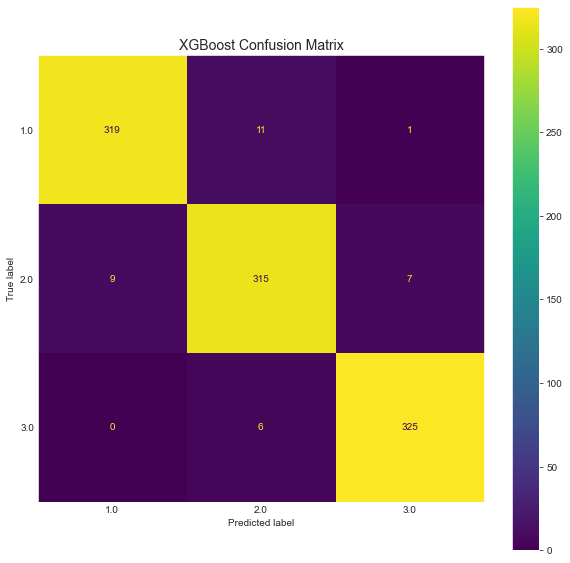

In [79]:
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('XGBoost Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

In [80]:
print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))

              precision    recall  f1-score   support

      Normal       0.97      0.96      0.97       331
     Suspect       0.95      0.95      0.95       331
Pathological       0.98      0.98      0.98       331

    accuracy                           0.97       993
   macro avg       0.97      0.97      0.97       993
weighted avg       0.97      0.97      0.97       993



<b>Update:</b> With the SMOTE data included, XGBoost improves considerably. 

It seems we can't use categorical data with the tree method used. Lets now try CatBoost Classifier

In [81]:
def objective(trial, X_smote=X_smote, y_smote=y_smote):
    
    X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state=3, test_size=0.25) #Still does better with no stratify
    
    param_grid = {
        'l2_leaf_reg' : trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),
        'min_child_samples' : trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        #'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 2000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,16]),
        'random_state': trial.suggest_categorical('random_state', [24, 48, 2020]),
        'grow_policy' : 'Depthwise',
        'use_best_model' : True,
        'od_type' : 'iter', 
        'od_wait' : 20
    }
    
    clf = CatBoostClassifier(**param_grid)  
    
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    y_pred = clf.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='micro')
    
    #return rmse 
    return f1

In [82]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-05-27 10:06:22,895] A new study created in memory with name: no-name-53cb6c09-ab73-4805-b11a-8e591b6e1366
[I 2022-05-27 10:07:20,006] Trial 0 finished with value: 0.9830917874396136 and parameters: {'l2_leaf_reg': 3.0, 'min_child_samples': 32, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 2020}. Best is trial 0 with value: 0.9830917874396136.
[I 2022-05-27 10:07:34,551] Trial 1 finished with value: 0.9798711755233495 and parameters: {'l2_leaf_reg': 4.0, 'min_child_samples': 4, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 2020}. Best is trial 0 with value: 0.9830917874396136.
[I 2022-05-27 10:08:39,824] Trial 2 finished with value: 0.9838969404186796 and parameters: {'l2_leaf_reg': 4.0, 'min_child_samples': 8, 'learning_rate': 0.014, 'max_depth': 11, 'random_state': 2020}. Best is trial 2 with value: 0.9838969404186796.
[I 2022-05-27 10:09:08,304] Trial 3 finished with value: 0.9830917874396136 and parameters: {'l2_leaf_reg': 1.0, 'min_child_samples': 4, 'l

[I 2022-05-27 11:38:41,370] Trial 31 finished with value: 0.9863123993558777 and parameters: {'l2_leaf_reg': 1.5, 'min_child_samples': 1, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 48}. Best is trial 10 with value: 0.9863123993558777.
[I 2022-05-27 11:43:08,961] Trial 32 finished with value: 0.9863123993558777 and parameters: {'l2_leaf_reg': 1.5, 'min_child_samples': 1, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 48}. Best is trial 10 with value: 0.9863123993558777.
[I 2022-05-27 11:47:53,628] Trial 33 finished with value: 0.9838969404186796 and parameters: {'l2_leaf_reg': 1.0, 'min_child_samples': 1, 'learning_rate': 0.014, 'max_depth': 13, 'random_state': 48}. Best is trial 10 with value: 0.9863123993558777.
[I 2022-05-27 11:48:24,225] Trial 34 finished with value: 0.9871175523349437 and parameters: {'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 2020}. Best is trial 34 with value: 0.9871175523349437.
[I 202

Number of finished trials: 50
Best trial: {'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'learning_rate': 0.02, 'max_depth': 15, 'random_state': 48}


In [83]:
optuna.visualization.plot_optimization_history(study) 

In [66]:
best_args = {'l2_leaf_reg': 1.5,
 'min_child_samples': 8,
 'learning_rate': 0.01,
 'max_depth': 15,
 'random_state': 48}
best_args

{'l2_leaf_reg': 1.5,
 'min_child_samples': 8,
 'learning_rate': 0.01,
 'max_depth': 15,
 'random_state': 48}

After iterating through some different combinations of parameters, this set of parameters yeilds the best results for this
algorithm/model.

In [67]:
clf = CatBoostClassifier(n_estimators = 2000, grow_policy = 'Depthwise', use_best_model = True, od_type = 'iter', od_wait = 20, **best_args)  
    
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
y_pred = clf.predict(X_test)
    
f1 = f1_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
acc = accuracy_score(y_test, y_pred)

print()
print('CatBoost Classifier Optuna F1-Score: {:.2%}'.format(f1))
print('CatBoost Classifier Optuna Precision Score: {:.2%}'.format(precision))
print('CatBoost Classifier Optuna Recall Score: {:.2%}'.format(recall))
print('CatBoost Classifier Optuna Accuracy Score: {:.2%}'.format(acc))


CatBoost Classifier Optuna F1-Score: 93.42%
CatBoost Classifier Optuna Precision Score: 93.42%
CatBoost Classifier Optuna Recall Score: 93.42%
CatBoost Classifier Optuna Accuracy Score: 93.42%


This model without using the extra artificial data doesn't perform as well, but still performs quite well achieving 93.42% accuracy as well as F1-score.

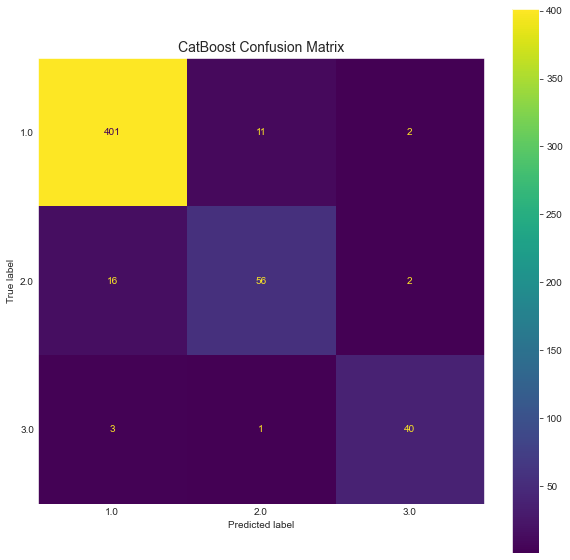

In [68]:
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('CatBoost Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

In [69]:
print(classification_report(y_test, y_pred, target_names = ['Normal', 'Suspect', 'Pathological']))

              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96       414
     Suspect       0.82      0.76      0.79        74
Pathological       0.91      0.91      0.91        44

    accuracy                           0.93       532
   macro avg       0.90      0.88      0.89       532
weighted avg       0.93      0.93      0.93       532



This final model classifies the unseen test data very well. Of course the weakest category is still the suspect records. Aside from just a couple incorrectly identified records, we had 15 records predicted to be normal but were actually suspect (<b>false negatives</b>). These types of records I believe are the most difficult to distinguish since some records could be more on the side of the spectrum of normal than pathological. 

Looking at our classification report, our lowest metric by far was the recall score for suspect records.

<b>Recall Formula: TP / (TP + FN) </b>

We can see that what drives this score down are those 15 false negatives for suspect records. This recall score for suspect records is also the highest across all models we have attempted here. Therefore, in comparison to the other algorithms used, we have arrived at a conclusive model.

<b>Update:</b> With the results of the SMOTE implementation with CatBoost being nearly perfect, I will include the ROC AUC curve for some of the models below:

In [70]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc
from sklearn.preprocessing import label_binarize #Since we have multiple classes, we need to binarize the target variable

In [75]:
pred_prob3 = clf.predict_proba(X_test) #CatBoost

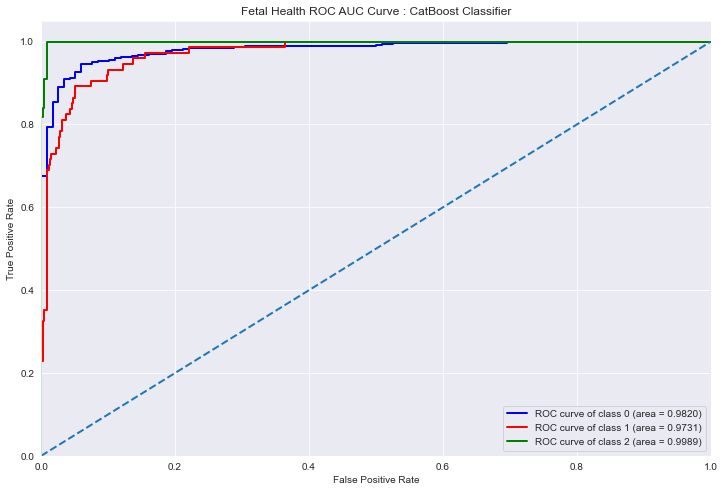

In [77]:
y_test_bin = label_binarize(y_test, classes=[1,2,3])
plt.figure(figsize=(12,8))

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred_prob3[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i, color in zip(range(3), ['blue', 'red', 'green']):
    plt.plot(fpr[i], tpr[i], color = color,lw = 2, label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))
    

plt.plot([0, 1], [0, 1], linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fetal Health ROC AUC Curve : CatBoost Classifier')
plt.legend()
plt.show()

Since we have updated our best overall model, we can update the pickled model file as such below:

### Exporting Model to Pickle

In [80]:
import joblib 
import pickle


In [81]:
pickl = {'model' : clf}
pickle.dump(pickl, open('model_file'+'.p', 'wb'))

In [82]:
file_name = 'model_file.p'
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

In [83]:
model.predict(X_test[1, :].reshape(1, -1))

array([[1.]])

In [84]:
X_test[1, :]

array([-0.64001527, -0.81598533, -0.1946691 ,  1.22870557,  2.07981293,
       -0.06146818, -0.26580404, -1.68742603,  1.31227853, -0.53991258,
        1.92342805,  0.33067523, -0.60323534, -0.2765876 ,  0.32760939,
       -0.46925751, -1.05824525, -1.05537804, -1.18069553,  0.04443419,
       -0.51941732, -0.44366701, -0.75640984,  0.93409125])

In [85]:
print(list(pd.Series(X_test[1, :])))

[-0.6400152661057144, -0.8159853294959482, -0.19466910311613028, 1.2287055719423972, 2.0798129271004173, -0.061468183082682246, -0.26580403861374097, -1.687426027854312, 1.3122785312624057, -0.5399125810401717, 1.9234280504254315, 0.33067522912313646, -0.6032353351825549, -0.27658759653976933, 0.3276093948580599, -0.469257511887606, -1.0582452490869203, -1.0553780367875873, -1.1806955345294805, 0.04443418629485109, -0.519417319911251, -0.4436670086602551, -0.756409835344031, 0.9340912540874498]
